In [39]:
import pandas as pd
import numpy as np

In [40]:
df = pd.read_csv('CleanedData.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12226 entries, 0 to 12225
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   body       12208 non-null  object
 1   Depressed  12226 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 191.2+ KB


In [41]:
df.Depressed.value_counts()

0    8996
1    3230
Name: Depressed, dtype: int64

In [42]:
i = 0
for a in range(len(df)):
  if(df.loc[a,'Depressed'] == 1):
    continue
  else:
    if(i > 3230):
      df = df.drop(a)
    else:
      i += 1

In [43]:
df.Depressed.value_counts()

0    3231
1    3230
Name: Depressed, dtype: int64

In [44]:
df = df.sample(frac=1).reset_index(drop=True)

In [45]:
validate = df[:500]
df = df[0:len(df)-500]

In [46]:
!pip install pyspellchecker

In [47]:
!pip install autocorrect

In [48]:
from textblob import TextBlob
from autocorrect import Speller
from spellchecker import SpellChecker
def fuzzyLogic(text):
  spell = Speller(lang='en')
  text = str(spell(text))
  return text

In [49]:
fuzzyLogic('kisha they cnt get over u til they get out frm under u just remember ur on top ')

'sha they cnt get over u til they get out frm under u just remember ur on top '

In [50]:
import re
df = df.reset_index(drop=True)
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')

import spacy
#loading the english language small model of spacy
en = spacy.load('en_core_web_sm')
sw_spacy = en.Defaults.stop_words

def clean_text(text):
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
    words = [word for word in text.split() if word.lower() not in sw_spacy]
    text = " ".join(words)
    return text

In [51]:
df = df.dropna()
from tensorflow.keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 50000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 125
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['body'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 17131 unique tokens.


In [52]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(df['body'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (5953, 125)


In [53]:
Y = pd.get_dummies(df['Depressed']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (5953, 2)


In [54]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.25, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(4464, 125) (4464, 2)
(1489, 125) (1489, 2)


In [55]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Embedding, SpatialDropout1D, LSTM, Dense,GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(GRU(128, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(64))
model.add(Dense(2, activation='softmax'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

epochs = 9
batch_size = 1024

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size,validation_split=0.1,callbacks=[EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])


Epoch 1/9
4/4 [==============================] - 16s 3s/step - loss: 0.6915 - accuracy: 0.4927 - val_loss: 0.6864 - val_accuracy: 0.5056
Epoch 2/9
4/4 [==============================] - 13s 3s/step - loss: 0.6776 - accuracy: 0.6517 - val_loss: 0.6674 - val_accuracy: 0.8233
Epoch 3/9
4/4 [==============================] - 13s 3s/step - loss: 0.6408 - accuracy: 0.9019 - val_loss: 0.6090 - val_accuracy: 0.8747
Epoch 4/9
4/4 [==============================] - 13s 3s/step - loss: 0.5364 - accuracy: 0.9076 - val_loss: 0.4744 - val_accuracy: 0.8188
Epoch 5/9
4/4 [==============================] - 13s 3s/step - loss: 0.3902 - accuracy: 0.8718 - val_loss: 0.3604 - val_accuracy: 0.8859
Epoch 6/9
4/4 [==============================] - 13s 3s/step - loss: 0.2642 - accuracy: 0.9325 - val_loss: 0.2462 - val_accuracy: 0.9060
Epoch 7/9
4/4 [==============================] - 13s 3s/step - loss: 0.1606 - accuracy: 0.9455 - val_loss: 0.1970 - val_accuracy: 0.9060
Epoch 8/9
4/4 [==========================

In [56]:
accr = model.evaluate(X_test,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

47/47 [==============================] - 2s 37ms/step - loss: 0.1102 - accuracy: 0.9523
Test set
  Loss: 0.110
  Accuracy: 0.952


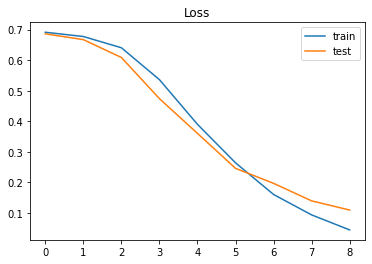

In [57]:
import matplotlib.pyplot as plt
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show();

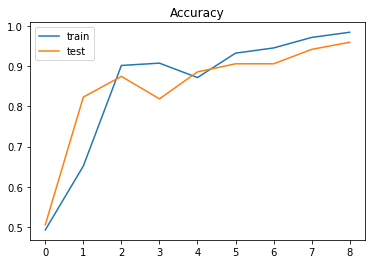

In [58]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

In [59]:
val = validate

In [60]:
val

,body,Depressed
0,elliottkember press log phone aol theyve locked,0
1,im tired unbearably lazy hurts cant muster lot...,1
2,distant dwell misery trigger depression happy ...,1
3,amber_benson awesomewhat tell,0
4,kerryn thanks appreciate feedback,0
...,...,...
495,whoaitsjess ah love song,0
496,pjredd read quot atmospheremongeringquot mista...,0
497,trying watch olympics cool year making bummed ...,1
498,thread months ago took steps address mental he...,1


In [61]:
val.Depressed.value_counts()

1    260
0    240
Name: Depressed, dtype: int64

In [62]:
val = val.dropna()
val['body'] = val['body'].apply(clean_text)
val['body'] = val['body'].str.replace('\d+', '')
X1 = tokenizer.texts_to_sequences(val['body'].values)
X1 = pad_sequences(X1, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X1.shape)
Y1 = pd.get_dummies(val['Depressed']).values
print('Shape of label tensor:', Y1.shape)

Shape of data tensor: (500, 125)
Shape of label tensor: (500, 2)


In [63]:
accr = model.evaluate(X1,Y1)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

16/16 [==============================] - 1s 39ms/step - loss: 0.0571 - accuracy: 0.9780
Test set
  Loss: 0.057
  Accuracy: 0.978


In [64]:
def isDepressing(text):
  text = fuzzyLogic(text)
  lst = {'body':[text]}
  # Calling DataFrame constructor on list  
  dframe = pd.DataFrame(lst) 
  dframe = dframe['body'].apply(clean_text)
  dframe = dframe.str.replace('\d+', '')
  X1 = tokenizer.texts_to_sequences(dframe.values)
  X1 = pad_sequences(X1, maxlen=MAX_SEQUENCE_LENGTH)
  print('Shape of data tensor:', X1.shape)
  a = model.predict(X1)
  print(a)
  if(a[0][0] > a[0][1]):
    return 0
  return 1

In [76]:
isDepressing("I always feel sad and depressed")

Shape of data tensor: (1, 125)
[[0.207816   0.79218405]]


1

In [66]:
df

,body,Depressed
0,elliottkember press log phone aol theyve locked,0
1,im tired unbearably lazy hurts cant muster lot...,1
2,distant dwell misery trigger depression happy ...,1
3,amber_benson awesomewhat tell,0
4,kerryn thanks appreciate feedback,0
...,...,...
5956,hmmdid know + million people suffer depression...,1
5957,eating mommymade mac camp cheese best kind,0
5958,parents concerned teenager depression join nim...,1
5959,jessieeeeeh hiya man aint working hi,0


In [67]:
val2 = pd.read_csv('shot1.csv')[:250]

In [68]:
val2['Depressed'] = 0
for i in range(len(val2)):
  if(val2.loc[i,'class'] == 'suicide'):
    val2.loc[i,'Depressed'] = 1
val2 = val2.rename(columns = {'text':'body'})
val2 = val2[['body','Depressed']]

In [69]:
val2.Depressed.value_counts()

0    132
1    118
Name: Depressed, dtype: int64

In [70]:
val2

,body,Depressed
0,Ex Wife Threatening SuicideRecently I left my ...,1
1,Am I weird I don't get affected by compliments...,0
2,Finally 2020 is almost over... So I can never ...,0
3,i need helpjust help me im crying so hard,1
4,"I’m so lostHello, my name is Adam (16) and I’v...",1
...,...,...
245,"Me explaining to my mom what ""based"" means If ...",0
246,I attempted suicide and obviously failed in th...,1
247,Someone VC w me on discord I'm bored as hell i...,0
248,I just want her back.Me and my ex girlfriend h...,1


In [71]:
for i in range(len(val2)):
    val2.loc[i,'body'] = fuzzyLogic(val2.loc[i,'body'])
val2['body'] = val2['body'].apply(clean_text)
val2['body'] = val2['body'].str.replace('\d+', '')
X11 = tokenizer.texts_to_sequences(val2['body'].values)
X11 = pad_sequences(X11, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X11.shape)
Y11 = pd.get_dummies(val2['Depressed']).values
print('Shape of label tensor:', Y11.shape)

Shape of data tensor: (250, 125)
Shape of label tensor: (250, 2)


In [72]:
accr = model.evaluate(X11,Y11)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

8/8 [==============================] - 0s 36ms/step - loss: 2.6839 - accuracy: 0.6080
Test set
  Loss: 2.684
  Accuracy: 0.608
